# Unsplash Image Search

The project allows you to search images on [Unsplash](https://unsplash.com/) by using a natural word description. It is powered by OpenAI's [CLIP model](https://github.com/openai/CLIP).

Use this notebook to search for images on [Unsplash](https://unsplash.com/).

## Search

The search process contains two steps:
1. Search Unsplash based on some more general keywords and retrieve a large amount of photos.
2. Evaluate how good each of the photos matches the description using CLIP. The best photos are chosen and displayed.

You need to provide 3 parameters for the search:
* `description` - a natural language description of what you want to see in the photo
* `search_keywords` - broad keywords used for initial photos-selection
* `search_count` - number of photos to get for the initial selection

In [ ]:
! pip install -q clip ipyplot

In [ ]:
description = "woman handbag"
search_keywords = "handba"
search_count = 10

## Donwload the Photos

We need to retrieve the Unsplash API key so that we can make calls to the API.

In [ ]:
# from dotenv import load_dotenv
# load_dotenv()

import os
unsplash_access_key = os.getenv('UCcfBkfvPc_f1y72j8IonoUgr_XYzAWf6ROFBvFItWk')

We need to first searches Unsplash for photos matching the provided keywords for the initial selection.

In [ ]:
import os
import math
import json
from urllib.request import Request, urlopen
from urllib.parse import quote_plus

# Convert the search keywords in a format suitable for the API
query_string = quote_plus(search_keywords)

# Compute how much pages we need to fetch fromt he search results (assuming 20 photos per page)
photos_per_page = 20
pages_count = math.ceil(search_count/photos_per_page)

# Go through each search result page and store the URLs and metadata of the photos
photos_data = []
for page in range(0, pages_count):
    # Make an authenticated call to the API and parse the results as JSON
    # request = Request(f"https://api.unsplash.com/search/photos?page={page+1}&per_page={photos_per_page}&query={query_string}&client_id={unsplash_access_key}")
    request = Request(f"https://api.unsplash.com/search/photos/?page=1&query=woman%20handbag&client_id=UCcfBkfvPc_f1y72j8IonoUgr_XYzAWf6ROFBvFItWk")
    # request.add_header("Authorization", f"client_id {unsplash_access_key}")
    response = urlopen(request).read().decode("utf-8")
    search_result = json.loads(response)

    # Add each photo URL to the list
    for photo in search_result['results']:
        photos_data.append(dict(url=photo['urls']['raw'],
                               link=photo['links']['html'],
                               user_name=photo['user']['name'],
                               user_link=photo['user']['links']['html'],))

# Display some statistics
display(f'Photos found: {len(photos_data)}')

'Photos found: 10'

After that, we need to download all the selected photos. We download the photos in parallel using 16 threads.

In [ ]:
from urllib.request import urlopen
from multiprocessing.pool import ThreadPool
from PIL import Image

# Function used to load a photo from the API
# The photos are downloaded in a small resolution (max 500 pixels wide), because CLIP only supports 224x224 images
def load_photo(url):
    return Image.open(urlopen(url + "&w=500"))

# Parallelize the download using a thread pool
photo_urls = [photo['url'] for photo in photos_data]
pool = ThreadPool(16)
photos = pool.map(load_photo, photo_urls)

# Display some statistics
display(f'Photos downloaded: {len(photos)}')

'Photos downloaded: 10'

We can now display the photos from the initial selection. They will not yet match you natural language description.

In [ ]:
import ipyplot

# Sort the photos by
photos_heights = [photo.height for photo in photos]
photos_with_heights = zip(photos_heights, photos)
photos_sorted = sorted(photos_with_heights, key=lambda x: x[0])
photos_sorted = [photo[1] for photo in photos_sorted]

# Display the images from the search query representing our initial selection
ipyplot.plot_images(photos_sorted, labels=[""]*search_count, max_images=search_count, img_width=100)

## Processing with CLIP

Now we need to process the photos with CLIP. We are basically converting them in a vector space, where they can be compared to a text description. We do the same with the description.

In [ ]:
! pip install clip

In [ ]:
# pip install accelerate
import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xxl")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xxl", device_map="auto")


raw_image = Image.open(path_to_image).convert('RGB')

question = "how many dogs are in the picture?"
inputs = processor(raw_image, question, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

In [ ]:
import clip
import torch

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

with torch.no_grad():
    # Encode and normalize the description using CLIP
    description_encoded = model.encode_text(clip.tokenize(description).to(device))
    description_encoded /= description_encoded.norm(dim=-1, keepdim=True)

    # Preprocess all photos and stack them in a batch
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    # Encode and normalize the photos using CLIP
    photos_encoded = model.encode_image(photos_preprocessed)
    photos_encoded /= photos_encoded.norm(dim=-1, keepdim=True)

## Evaluate similarity

Now we can compare each photo to the text description and sort them by similarity

In [ ]:
# Retrieve the description vector and the photo vectors
description_vector = description_encoded.cpu().numpy()
photo_vectors = photos_encoded.cpu().numpy()

# Compute the similarity between the descrption and each photo using the Cosine similarity
similarities = list((description_vector @ photo_vectors.T).squeeze(0))

# Sort the photos by their similarity score
best_photos = sorted(zip(similarities, range(len(photos))), key=lambda x: x[0], reverse=True)

Finally, we can display the best 3 photos

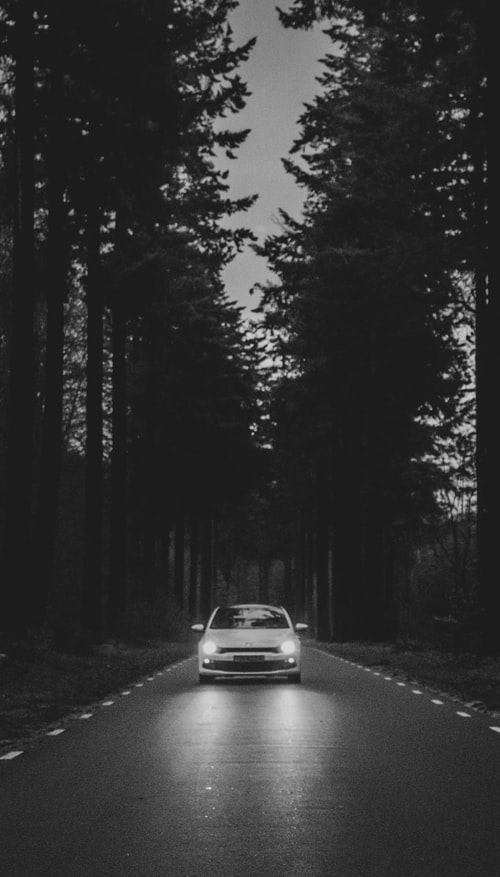

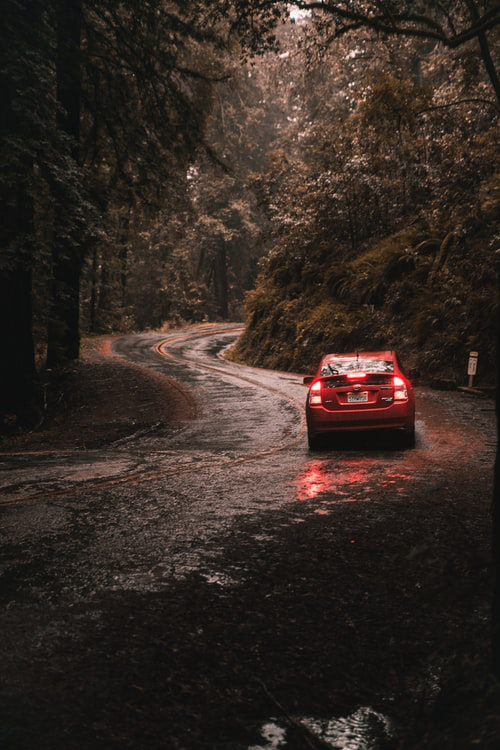

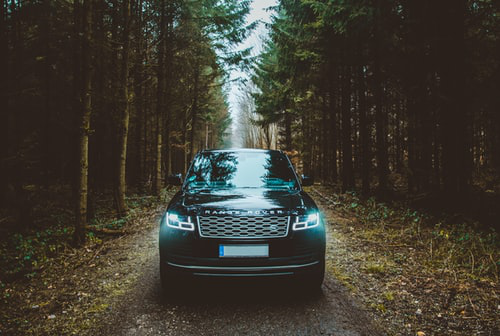

In [ ]:
from IPython.core.display import HTML

# Display the best photos
for i in range(3):
    # Display the photo
    display(photos[best_photos[i][1]])

    # Display the attribution text
    photo_data = photos_data[best_photos[i][1]]
    display(HTML(f'Photo by <a href="{photo_data["user_link"]}?utm_source=NaturalLanguageImageSearch&utm_medium=referral">{photo_data["user_name"]}</a> on <a href="https://unsplash.com/?utm_source=NaturalLanguageImageSearch&utm_medium=referral">Unsplash</a>'))
    print()